## TOL Performance : Monthly

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import datetime

## Import Data Source

In [10]:
data_src = "../Raw-Agg Perf Nationwide_Wk 2023021.csv"
df = pd.read_csv(data_src, low_memory=False)
cols = ['TM_KEY_DAY', 'TM_KEY_WK', 'TM_KEY_MTH', 'TM_KEY_YR', 'CENTER', 'METRIC_GRP', 'COMP_CD', 'PRODUCT_GRP', 'METRIC_CD', 'METRIC_NAME', 'ACTUAL_AS_OF', 'AGG_TYPE', 'RR_IND', 'GRY_IND', 'UOM', 'PERIOD', 'ACTUAL_SNAP', 'ACTUAL_AGG', 'TARGET_SNAP', 'TARGET_AGG', 'PPN_TM']
tol_rev_cd_list = ['TB3R000100', 'TB3R000101', 'TB3R000102']

df = df[df['TM_KEY_MTH'] <= 202305] # filter
df = df[df['METRIC_CD'].isin(tol_rev_cd_list)].reset_index()
df.tail(3)

,index,TM_KEY_DAY,TM_KEY_WK,TM_KEY_MTH,TM_KEY_QTR,TM_KEY_YR,DAY_DESC,MONTH_DESC,QUARTER_DESC,COMP_CD,...,SEQ,PRIORITY,REMARK,AREA_TYPE,AREA_CD,AREA_NAME,REMARK_ACTUAL,REMARK_TARGET,PPN_TM,METRIC_NAME_GROUP
273,41753,20230529,2023022,202305,20232,2023,Monday,May,Quarter 2,TRUE,...,2341.0,High,NaN,P,P,Nationwide,NaN,NaN,2023-06-02 17:46:25,TOL Revenue
274,41754,20230530,2023022,202305,20232,2023,Tuesday,May,Quarter 2,TRUE,...,2341.0,High,NaN,P,P,Nationwide,NaN,NaN,2023-06-02 17:46:25,TOL Revenue
275,41755,20230531,2023022,202305,20232,2023,Wednesday,May,Quarter 2,TRUE,...,2341.0,High,NaN,P,P,Nationwide,NaN,Bill Cycle,2023-06-02 17:46:25,TOL Revenue


In [11]:
# df.groupby(['CENTER', 'METRIC_GRP', 'COMP_CD', 'PRODUCT_GRP', 'METRIC_CD', 'METRIC_NAME']).size().reset_index()
df.shape

(276, 55)

## Data prep

In [ ]:
# ''' Find Metric '''
# df_metric = df.groupby(['CENTER', 'METRIC_GRP', 'COMP_CD', 'PRODUCT_GRP', 'METRIC_CD', 'METRIC_NAME']).size().reset_index()

# df_tmp = df_metric[df_metric['PRODUCT_GRP']=="TOL"]
# df_tmp = df_tmp[df_tmp['METRIC_GRP']=="Revenue"]
# df_tmp = df_tmp[df_tmp['METRIC_NAME'].str.contains("Revenue")].reset_index()
# # df_tmp = df_tmp[df_tmp['COMP_CD']=="TRUE"]

# df_tmp

In [12]:
''' Function : Unit Million Baht '''
def unit_mb(baht):
    n = baht
    unit_mb = n / 1000000
    return unit_mb

''' Modify '''
df.loc[:, 'ACTUAL_SNAP'] = unit_mb(df['ACTUAL_SNAP'])
df.loc[:, 'ACTUAL_AGG'] = unit_mb(df['ACTUAL_AGG'])
df.loc[:, 'TARGET_SNAP'] = unit_mb(df['TARGET_SNAP'])
df.loc[:, 'TARGET_AGG'] = unit_mb(df['TARGET_AGG'])
df['MTH_DESC'] = pd.to_datetime(df['TM_KEY_MTH'], format='%Y%m', errors='coerce').dt.strftime('%B')

''' Datetime values '''
curr_yr = max(df['TM_KEY_YR'])
last_yr = max(df['TM_KEY_YR'])-1
curr_mth = max(df['TM_KEY_MTH'])
curr_mth_desc = pd.to_datetime(curr_mth, format='%Y%m', errors='coerce').strftime('%B')
last_mth = int(f'{str(last_yr)}01') if str(curr_mth)[4:]=='01' else curr_mth-1
curr_wk = max(df['TM_KEY_WK'])
curr_day = max(df['TM_KEY_DAY'])
last_ppn_tm = max(df['PPN_TM'])

# df.tail(3)

In [13]:
''' Revenue Rawdata '''
# df_rev = df.loc[:, ['TM_KEY_DAY', 'TM_KEY_WK', 'TM_KEY_MTH', 'METRIC_CD', 'METRIC_NAME', 'ACTUAL_SNAP', 'ACTUAL_AGG', 'TARGET_SNAP', 'TARGET_AGG', 'MTH_DESC']]
# df_rev.tail(3)

''' Pivot Actual by New & Existing '''
df_rev_act_pivot = df.pivot(index=['TM_KEY_DAY', 'TM_KEY_WK', 'TM_KEY_MTH', 'MTH_DESC'], columns=['METRIC_NAME'], values='ACTUAL_SNAP').reset_index()
df_rev_act_pivot.rename(columns=({'TOL Revenue': 'ACTUAL', 'TOL New Revenue': 'ACTUAL_NEW', 'TOL Exisitng Revenue': 'ACTUAL_EXIST'}), inplace=True)

''' Pivot Target by New & Existing '''
df_rev_tgt_pivot = df.pivot(index='TM_KEY_DAY', columns='METRIC_NAME', values='TARGET_SNAP').reset_index()
df_rev_tgt_pivot.rename(columns=({'TOL Revenue': 'TARGET', 'TOL New Revenue': 'TARGET_NEW', 'TOL Exisitng Revenue': 'TARGET_EXIST'}), inplace=True)

''' Aggregation '''
df_rev_pivot_agg = pd.merge(df_rev_act_pivot, df_rev_tgt_pivot, on='TM_KEY_DAY')
df_rev_pivot_agg['WK_LABEL'] = df_rev_pivot_agg['TM_KEY_WK'].apply(str).str[5:].astype(int)
df_rev_pivot_agg['DAY_LABEL'] = df_rev_pivot_agg['TM_KEY_DAY'].apply(str).str[6:].astype(int)
df_rev_pivot_agg.tail()

METRIC_NAME,TM_KEY_DAY,TM_KEY_WK,TM_KEY_MTH,MTH_DESC,ACTUAL_EXIST,ACTUAL_NEW,ACTUAL,TARGET_EXIST,TARGET_NEW,TARGET,WK_LABEL,DAY_LABEL
87,20230527,2023021,202305,May,NaN,NaN,NaN,NaN,NaN,NaN,21,27
88,20230528,2023021,202305,May,0.02536,1.43408,1.45944,147.318778,18.468184,167.329939,21,28
89,20230529,2023022,202305,May,NaN,NaN,NaN,NaN,NaN,NaN,22,29
90,20230530,2023022,202305,May,NaN,NaN,NaN,NaN,NaN,NaN,22,30
91,20230531,2023022,202305,May,NaN,NaN,NaN,NaN,NaN,NaN,22,31


## Monthly Performance Aggregation

In [14]:
''' Rawdata by month '''
df_rev_mth = df_rev_pivot_agg.groupby(['TM_KEY_MTH', 'MTH_DESC']).sum(numeric_only=True)[['ACTUAL', 'ACTUAL_NEW', 'ACTUAL_EXIST', 'TARGET', 'TARGET_NEW', 'TARGET_EXIST']].reset_index()

''' Aggregation '''
df_rev_mth['%ACHIEVE'] = (df_rev_mth['ACTUAL'] / df_rev_mth['TARGET'])
df_rev_mth['%ACHIEVE_NEW'] = (df_rev_mth['ACTUAL_NEW'] / df_rev_mth['TARGET_NEW'])
df_rev_mth['%ACHIEVE_EXIST'] = (df_rev_mth['ACTUAL_EXIST'] / df_rev_mth['TARGET_EXIST'])
df_rev_mth['GAP'] = df_rev_mth['ACTUAL'] - df_rev_mth['TARGET']
df_rev_mth['GAP_NEW'] = df_rev_mth['ACTUAL_NEW'] - df_rev_mth['TARGET_NEW']
df_rev_mth['GAP_EXIST'] = df_rev_mth['ACTUAL_EXIST'] - df_rev_mth['TARGET_EXIST']
df_rev_mth['DIFF'] = df_rev_mth['ACTUAL'].diff()
df_rev_mth['DIFF_NEW'] = df_rev_mth['ACTUAL_NEW'].diff()
df_rev_mth['DIFF_EXIST'] = df_rev_mth['ACTUAL_EXIST'].diff()
df_rev_mth['LAST_ACTUAL'] = df_rev_mth['ACTUAL'] - df_rev_mth['DIFF']
df_rev_mth['LAST_ACTUAL_NEW'] = df_rev_mth['ACTUAL_NEW'] - df_rev_mth['DIFF_NEW']
df_rev_mth['LAST_ACTUAL_EXIST'] = df_rev_mth['ACTUAL_EXIST'] - df_rev_mth['DIFF_EXIST']
df_rev_mth['%MOM'] = (df_rev_mth['ACTUAL'] / df_rev_mth['LAST_ACTUAL']) - 1
df_rev_mth['%MOM_NEW'] = (df_rev_mth['ACTUAL_NEW'] / df_rev_mth['LAST_ACTUAL_NEW']) - 1
df_rev_mth['%MOM_EXIST'] = (df_rev_mth['ACTUAL_EXIST'] / df_rev_mth['LAST_ACTUAL_EXIST']) - 1

''' Chart values '''
x = df_rev_mth['MTH_DESC']
x_axis = np.arange(len(x))

y_act = df_rev_mth['ACTUAL'].round(2)
y_act_new = df_rev_mth['ACTUAL_NEW'].round(2)
y_act_exist = df_rev_mth['ACTUAL_EXIST'].round(2)
y_tgt = df_rev_mth['TARGET'].round(2)
y_tgt_new = df_rev_mth['TARGET_NEW'].round(2)
y_tgt_exist = df_rev_mth['TARGET_EXIST'].round(2)
y_ach = df_rev_mth['%ACHIEVE']
y_ach_new = df_rev_mth['%ACHIEVE_NEW']
y_ach_exist = df_rev_mth['%ACHIEVE_EXIST']
y_diff = df_rev_mth['DIFF'].round(2)
y_diff_new = df_rev_mth['DIFF_NEW'].round(2)
y_diff_exist = df_rev_mth['DIFF_EXIST'].round(2)
y_last_act = df_rev_mth['LAST_ACTUAL'].round(2)
y_last_act_new = df_rev_mth['LAST_ACTUAL_NEW'].round(2)
y_last_act_exist = df_rev_mth['LAST_ACTUAL_EXIST'].round(2)
y_mom = df_rev_mth['%MOM']
y_mom_new = df_rev_mth['%MOM_NEW']
y_mom_exist = df_rev_mth['%MOM_EXIST']

df_rev_mth

METRIC_NAME,TM_KEY_MTH,MTH_DESC,ACTUAL,ACTUAL_NEW,ACTUAL_EXIST,TARGET,TARGET_NEW,TARGET_EXIST,%ACHIEVE,%ACHIEVE_NEW,...,GAP_EXIST,DIFF,DIFF_NEW,DIFF_EXIST,LAST_ACTUAL,LAST_ACTUAL_NEW,LAST_ACTUAL_EXIST,%MOM,%MOM_NEW,%MOM_EXIST
0,202303,March,1401.402760,79.835657,1321.567103,1497.663311,118.312844,1379.350467,0.935726,0.674784,...,-57.783364,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,202304,April,1405.515708,104.253538,1301.262169,1506.832153,153.096289,1353.735864,0.932762,0.680967,...,-52.473694,4.112948,24.417881,-20.304933,1401.402760,79.835657,1321.567103,0.002935,0.305852,-0.015364
2,202305,May,1272.301320,120.711285,1151.590035,1516.000994,187.387036,1328.613958,0.839248,0.644182,...,-177.023923,-133.214387,16.457747,-149.672134,1405.515708,104.253538,1301.262169,-0.094780,0.157863,-0.115021


## TOL Revenue Summary Chart

/var/folders/4k/rll8vh6907l11_74m6bygwlc0000gn/T/ipykernel_3247/413573807.py:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs[:, 0])
/var/folders/4k/rll8vh6907l11_74m6bygwlc0000gn/T/ipykernel_3247/413573807.py:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax2 = plt.subplot(gs[:, 1:])


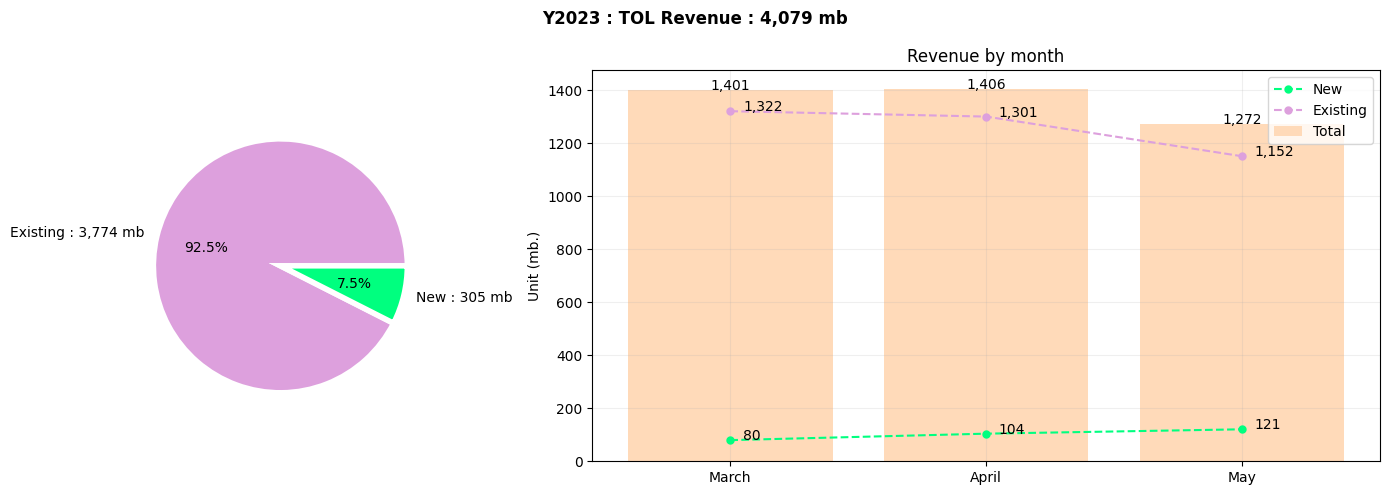

In [17]:
''' Revenue Summary Chart '''
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
fig.suptitle(f"Y{curr_yr} : TOL Revenue : {format(sum(y_act),',.0f')} mb", weight='bold')
gs = GridSpec(1, 3)
ax1 = plt.subplot(gs[:, 0])
ax2 = plt.subplot(gs[:, 1:])

''' ax1 '''
y = np.array([sum(y_act_exist), sum(y_act_new)])
mylabels = [f"Existing : {format(y[0],',.0f')} mb", f"New : {format(y[1],',.0f')} mb"]
mycolors = ["plum", "springgreen"]
ax1.pie(y, labels=mylabels, colors=mycolors, autopct='%1.1f%%', wedgeprops = {"linewidth": 4, "edgecolor": "white"})

''' ax2 '''
ax2.set_title('Revenue by month')
ax2.bar(x, y_act, label='Total', color='peachpuff')
ax2.plot(x, y_act_new, marker='.', linestyle='dashed', markeredgewidth=3, label='New', color='springgreen')
ax2.plot(x, y_act_exist, marker='.', linestyle='dashed', markeredgewidth=3, label='Existing', color='plum')
for i in x_axis:
    ax2.annotate(str(format(y_act[i],',.0f')), xy=(x_axis[i], y_act[i]), ha='center')
    ax2.annotate(str(format(y_act_new[i],',.0f')), xy=(x_axis[i]+0.05, y_act_new[i]))
    ax2.annotate(str(format(y_act_exist[i],',.0f')), xy=(x_axis[i]+0.05, y_act_exist[i]))
ax2.set_ylabel('Unit (mb.)', fontsize=10)
ax2.grid(alpha=0.2)
ax2.legend()

fig.tight_layout()
plt.show()

## TOL Performance Chart

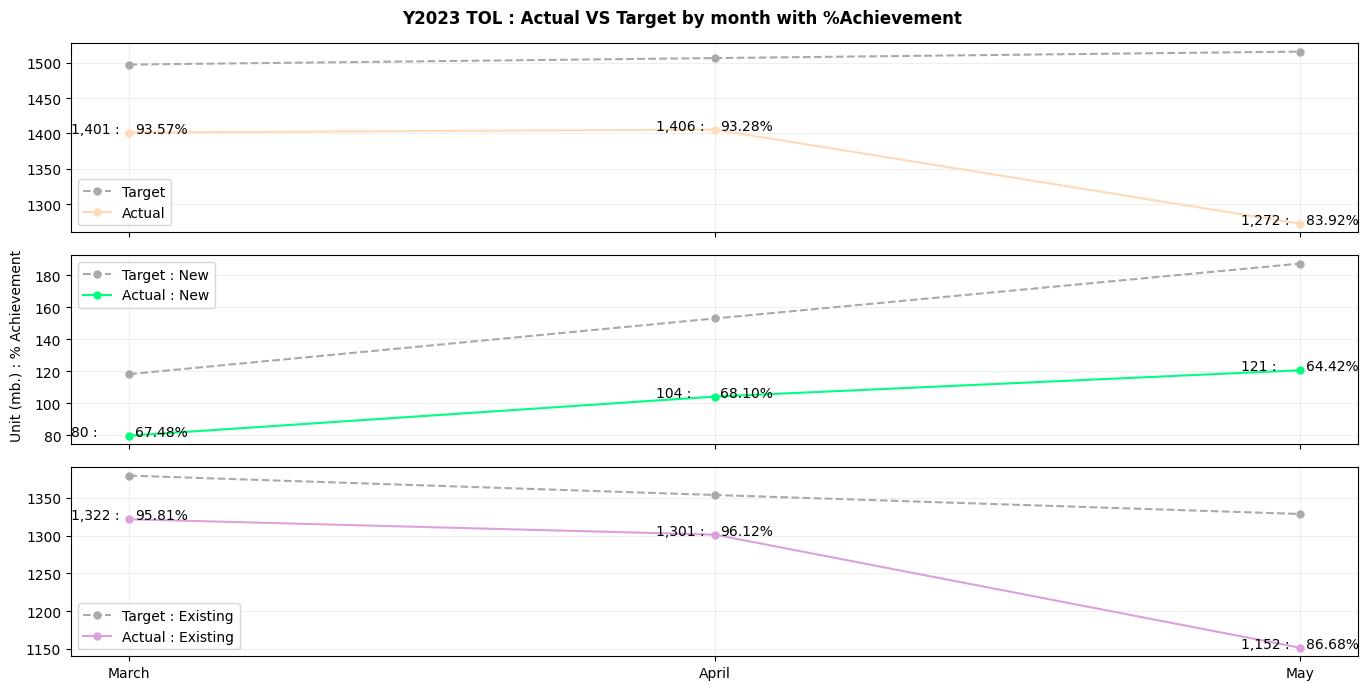

In [16]:
''' Peformance Chart '''
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(14, 7))
fig.suptitle(f'Y{curr_yr} TOL : Actual VS Target by month with %Achievement', weight='bold')

''' ax1 '''
ax1.plot(x, y_tgt, marker='.', linestyle='dashed', markeredgewidth=3, label='Target', color='darkgray')
ax1.plot(x, y_act, marker='.', markeredgewidth=3, label='Actual', color='peachpuff')
ax1.legend()
ax1.grid(alpha=0.2)
for i in x_axis:
    ax1.annotate(str(format(y_act[i],',.0f'))+' :', xy=(x_axis[i]-0.1, y_act[i]))
    ax1.annotate(str(format(y_ach[i],',.2%')), xy=(x_axis[i]+0.01, y_act[i]))

''' ax2 '''
ax2.plot(x, y_tgt_new, marker='.', linestyle='dashed', markeredgewidth=3, label='Target : New', color='darkgray')
ax2.plot(x, y_act_new, marker='.', markeredgewidth=3, label='Actual : New', color='springgreen')
ax2.legend()
ax2.grid(alpha=0.2)
for i in x_axis:
    ax2.annotate(str(format(y_act_new[i],',.0f'))+' :', xy=(x_axis[i]-0.1, y_act_new[i]))
    ax2.annotate(str(format(y_ach_new[i],',.2%')), xy=(x_axis[i]+0.01, y_act_new[i]))

''' ax3 '''
ax3.plot(x, y_tgt_exist, marker='.', linestyle='dashed', markeredgewidth=3, label='Target : Existing', color='darkgray')
ax3.plot(x, y_act_exist, marker='.', markeredgewidth=3, label='Actual : Existing', color='plum')
ax3.legend()
ax3.grid(alpha=0.2)
for i in x_axis:
    ax3.annotate(str(format(y_act_exist[i],',.0f'))+' :', xy=(x_axis[i]-0.1, y_act_exist[i]))
    ax3.annotate(str(format(y_ach_exist[i],',.2%')), xy=(x_axis[i]+0.01, y_act_exist[i]))

fig.supylabel('Unit (mb.) : % Achievement', fontsize=10)
fig.tight_layout()

plt.show()